**1. INTRODUCTION**

This is my first work in Kaggle and in Machine Learning. I describe below the steps that I followed to understand the data and create the prediction model .

**2. GET DATA**

In [ ]:
import os
import numpy as np
import pandas as pd

#create train dataframe
train_df=pd.read_csv("../input/train.csv")
#create test dataframe
test_df=pd.read_csv("../input/test.csv")
#view my train data
train_df.head()

** 3. DATA SUMMARY:**

In [ ]:
print("Train data Information")
train_df.info()
print("Test data Information")
test_df.info()

Total number of features: 13

'Survived' column classifies the record and is the actual Output.

'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' are non-numeric columns.

*** TRAIN DATA :***

Total number of records: 891

'Cabin' , 'Age' and 'Embarked' features have NULL/NaN values.


***TEST DATA :***

Total number of records: 418

'Cabin' , 'Age' and 'Fare' features have NULL/NaN values.



In [ ]:
print("######UNIQUE VALUES#######")
print("Unique values for Embarked")
print(pd.unique(train_df['Embarked']))
print("Unique values for Pclass")
print(pd.unique(train_df['Pclass']))
print("Unique values for Survived")
print(pd.unique(train_df['Survived']))
print("Unique values for Sex")
print(pd.unique(train_df['Sex']))
print("Unique values for SibSp")
print(pd.unique(train_df['SibSp']))
print("Unique values for Parch")
print(pd.unique(train_df['Parch']))
print("")
print("########TRAIN TEST#########")
print("No of NULL/NaN in Cabin")
print(sum(pd.isnull(train_df['Cabin'])))
print("No of NULL/NaN in Age")
print(sum(pd.isnull(train_df['Age'])))
print("No of NULL/NaN in Embarked")
print(sum(pd.isnull(train_df['Embarked'])))
print("")
print("########TRAIN TEST#########")
print("No of NULL/NaN in Cabin")
print(sum(pd.isnull(test_df['Cabin'])))
print("No of NULL/NaN in Age")
print(sum(pd.isnull(test_df['Age'])))
print("No of NULL/NaN in Fare")
print(sum(pd.isnull(test_df['Fare'])))


 **4. DATA PREPARATION**

***4.1 )     FIND THE MISSING AGE VALUES***
                
                4.1.1) OBSERVATIONS ON AGE DATA



In [ ]:
print("mean: ",train_df["Age"].mean())
print("median: ",train_df["Age"].median())
print("mode: ",train_df["Age"].mode())
x=train_df.groupby(["Age"])["Age"].agg(["count"]).reset_index()
plt.bar(x["Age"],x["count"])
plt.show()


The histogram is right skewed so if we take mean then it will be a value in the older age but in the ship the concentration of people is in the range 18 to 30. So we take a median value .

In [ ]:
train_df.loc[train_df["Age"].isnull()].groupby(["Pclass","Sex"])["Sex"].agg(["count"])

Missing age per class count:  class 1 is 136, class 2 is 11 and class 1 is 30. Also 158 out of 177 (i.e 89%) of the people where age is missing, the cabin is also missing.

In [ ]:
x=train_df.loc[train_df["Age"].isnull()].groupby(["Fare"])["Fare"].agg(["count"])
plt.plot(x)
plt.show()

The one with lower Fare has most missing Age count

In [ ]:
train_df.groupby(["Sex","SibSp","Parch"])["Age"].agg(["median"])

We see a 'NaN' where sibling/spouse count is 8.

In [ ]:
train_df.loc[train_df["SibSp"]==8]

One important inside from the above data is that Ticket and last name relates persons together; and also embarked as people of same group board from same port mostly. 

In [ ]:
xx=train_df.groupby(["Fare"])["Age"].agg(["mean"])
plt.plot(xx)
plt.show()


Mostly people with age 0 to 20 lie in the low fare zone (0 to 50).  

Age also depends on Sex and the Name title prefix. So lets take a look at that. Also possiblity is that a children will not travel without parents and when the number of Parch increases the age should also increase. We are not taking into consideration Sibling/Spouse count as I find it can be confusing.

In [ ]:
#Name title prefix
train_df["Name_key"]=""
train_df["Name_key"]=train_df["Name"].str.split(',',expand=True)[1].str.split(' ',expand=True)[1]

In [ ]:
train_df.groupby(["Sex","Name_key","Parch"])["Age"].agg(["median"])

Here is a summarised data that can be used for finding missing age. 

What about Fare? Lets group Fare into classes. 

In [ ]:
train_df["Fare_Group"]=pd.cut(train_df["Fare"],range(0,350,50),right=False)
train_df["Fare_Group"]=train_df["Fare_Group"].astype("object")
train_df["Fare_Group"].fillna("[300,600)",inplace=True)

I find including Fare groups doesnot give me additonal useful information on Age. Fare is more related to class. So I am not taking Fare into count.
How ever I also have ingore the values 'Ms.' and 'Mme' in Name_key as I am not clear with its meaning.


In [ ]:
#Final Age median values depending on the key features to which the Age depends on
Age_values=train_df.loc[train_df["Name_key"].isin(['Dr.','Master.','Miss.','Mr.','Mrs.'])].groupby(["Sex","Pclass","Name_key","Parch"])["Age"].agg(["median"]).reset_index()
Age_values

I substitute "Age" by using above Age_values

In [ ]:

null_age=train_df.loc[train_df["Age"].isnull()][['PassengerId','Sex','Name_key','Pclass','Parch']]
result=pd.merge(Age_values,null_age,how='inner',on=['Sex','Name_key','Pclass','Parch'])
result=result.rename(columns={'median':"Age"})
train_df.set_index('PassengerId',inplace=True)
result.set_index('PassengerId',inplace=True)
train_df.update(result)
train_df.reset_index(inplace=True)


***4.2 ) FIND THE MISSING VALUES OF EMBARKED***

In [ ]:
x=train_df.groupby(["Embarked"])["Embarked"].agg(["count"])
x

I dont find any relationship of Embarked with other features so it can be an independent variable and I chose to substitute with the most common value 'S' (72.27%). 

In [ ]:
train_df.loc[train_df["PassengerId"]==62.0,"Embarked"]='S'
train_df.loc[train_df["PassengerId"]==830,"Embarked"]='S'

***4.3) FIND THE MISSING VALUES OF CABIN***
            
            I grouped the Cabin as per the first letter to see if any pattern is present.

In [ ]:
train_df["Cabin_prefix"]=train_df["Cabin"].str[0:1]
train_df.groupby(["Cabin_prefix","Pclass"])["Pclass"].agg(["count"]).reset_index()

In [ ]:
people=train_df.groupby(["Cabin_prefix"])["Cabin_prefix"].agg(["count"]).reset_index()
people["survived"]=train_df.loc[train_df["Survived"]==1].groupby(["Cabin_prefix"])["Cabin_prefix"].agg(["count"]).reset_index()["count"]
people["per_survived"]=(people["survived"]/people["count"])*100
plt.bar(people["Cabin_prefix"],people["per_survived"])
plt.show()

Looking at the graph it doesnot gives any pattern that can be used. Also the data is sparse. Dropping the column should not impact the final prediction.

In [ ]:
#dropping Cabin columns
train_df.drop(columns={"Cabin","Cabin_prefix"},inplace=True)

***4.4) FIND MISSING VALUE OF FARE IN TEST DATA***

In [ ]:
#take a look on the data
test_df.loc[test_df["Fare"].isnull()]

In [ ]:
#Checking mean values for age>50 
train_df.loc[train_df["Pclass"]==3].loc[train_df["Age"]>50].groupby(["Age","Sex"])["Fare"].agg(["mean"])

In [ ]:
train_df.loc[train_df["Pclass"]==3].loc[train_df["Age"]>50].groupby(["Sex"])["Fare"].agg(["mean"])

We use the value '7.518522' to substitute.

In [ ]:
test_df.loc[test_df["Fare"].isnull(),"Fare"]=7.518522

***4.5) Ticket and PassengerIDs***

Do I need the field ticket? Ticket seems to relate persons together . And person related has similar suvival chances. 
We use Ticket number and Spouse/Sibing count, Parent/Child and last name to group them together.

In [ ]:
#copy the required coloumns in a seperate dataframe
related_people=train_df[["PassengerId","Name","SibSp","Parch","Ticket","Embarked"]].copy()
related_people_t=test_df[["PassengerId","Name","SibSp","Parch","Ticket","Embarked"]].copy()
related_people=pd.concat([related_people_t,related_people])
related_people["Last_Name"]=""
related_people["Last_Name"]=related_people["Name"].str.split(",",expand=True)[0]
related_people["total_related"]=related_people["SibSp"]+related_people["Parch"]+1

X=related_people.loc[(related_people["SibSp"]>0)|(related_people["Parch"]>0)].groupby(["Last_Name","total_related"])["PassengerId"].agg(["count"])
X.reset_index(inplace=True)

#Group related people where titles are same and the SibSp and Parch count matches
Y=pd.DataFrame(X.loc[X["count"]==X["total_related"]]["Last_Name"])

######If we explore the data in Y we can see for 'Carter' we have two rows so we need to take special care of this.
######Z=Y.groupby(["Last_Name"])["Last_Name"].agg(["count"])
######Z.loc[Z["count"]>1]

Y["RGroup"]=Y["Last_Name"]
Y.drop_duplicates(inplace=True)
Y.set_index("Last_Name",inplace=True)
related_people["RGroup"]=""
related_people.set_index("Last_Name",inplace=True)
related_people.update(Y)
related_people.reset_index(inplace=True)

#update the RGroup for 'Carter'
#related_people.loc[related_people["RGroup"]=='Carter']
#tickets are 113760,224252
related_people.loc[related_people["Ticket"]=='113760',"RGroup"]="Carter_1"
related_people.loc[related_people["Ticket"]=='224252',"RGroup"]="Carter_2"



In [ ]:
####Update group for people who are travelling alone
Y=pd.DataFrame(related_people.loc[(related_people["SibSp"]==0)&(related_people["Parch"]==0)][["Last_Name","Ticket"]])
Y["RGroup"]=Y["Last_Name"]+'_'+Y["Ticket"]
Y.drop_duplicates(inplace=True)
Y.set_index(["Last_Name","Ticket"],inplace=True)
related_people.set_index(["Last_Name","Ticket"],inplace=True)
related_people.update(Y)
related_people.reset_index(inplace=True)

In [ ]:
####Update group for people who are related by ticket number
X=related_people.loc[related_people["RGroup"]==""].groupby(["Ticket","total_related"])["PassengerId"].agg(["count"])
X.reset_index(inplace=True)
#Group related people where tickets are same and the SibSp and Parch count matches
Y=pd.DataFrame(X.loc[X["count"]==X["total_related"]]["Ticket"])
Y["RGroup"]=Y["Ticket"]+'_R'
Y.drop_duplicates(inplace=True)
Y.set_index("Ticket",inplace=True)
related_people.set_index("Ticket",inplace=True)
related_people.update(Y)
related_people.reset_index(inplace=True)


The rest of the people who are not related I have extracted the data and manually found the relationship in excel.
#related_people.loc[related_people["RGroup"]==""].to_excel('sheet1.xlsx')

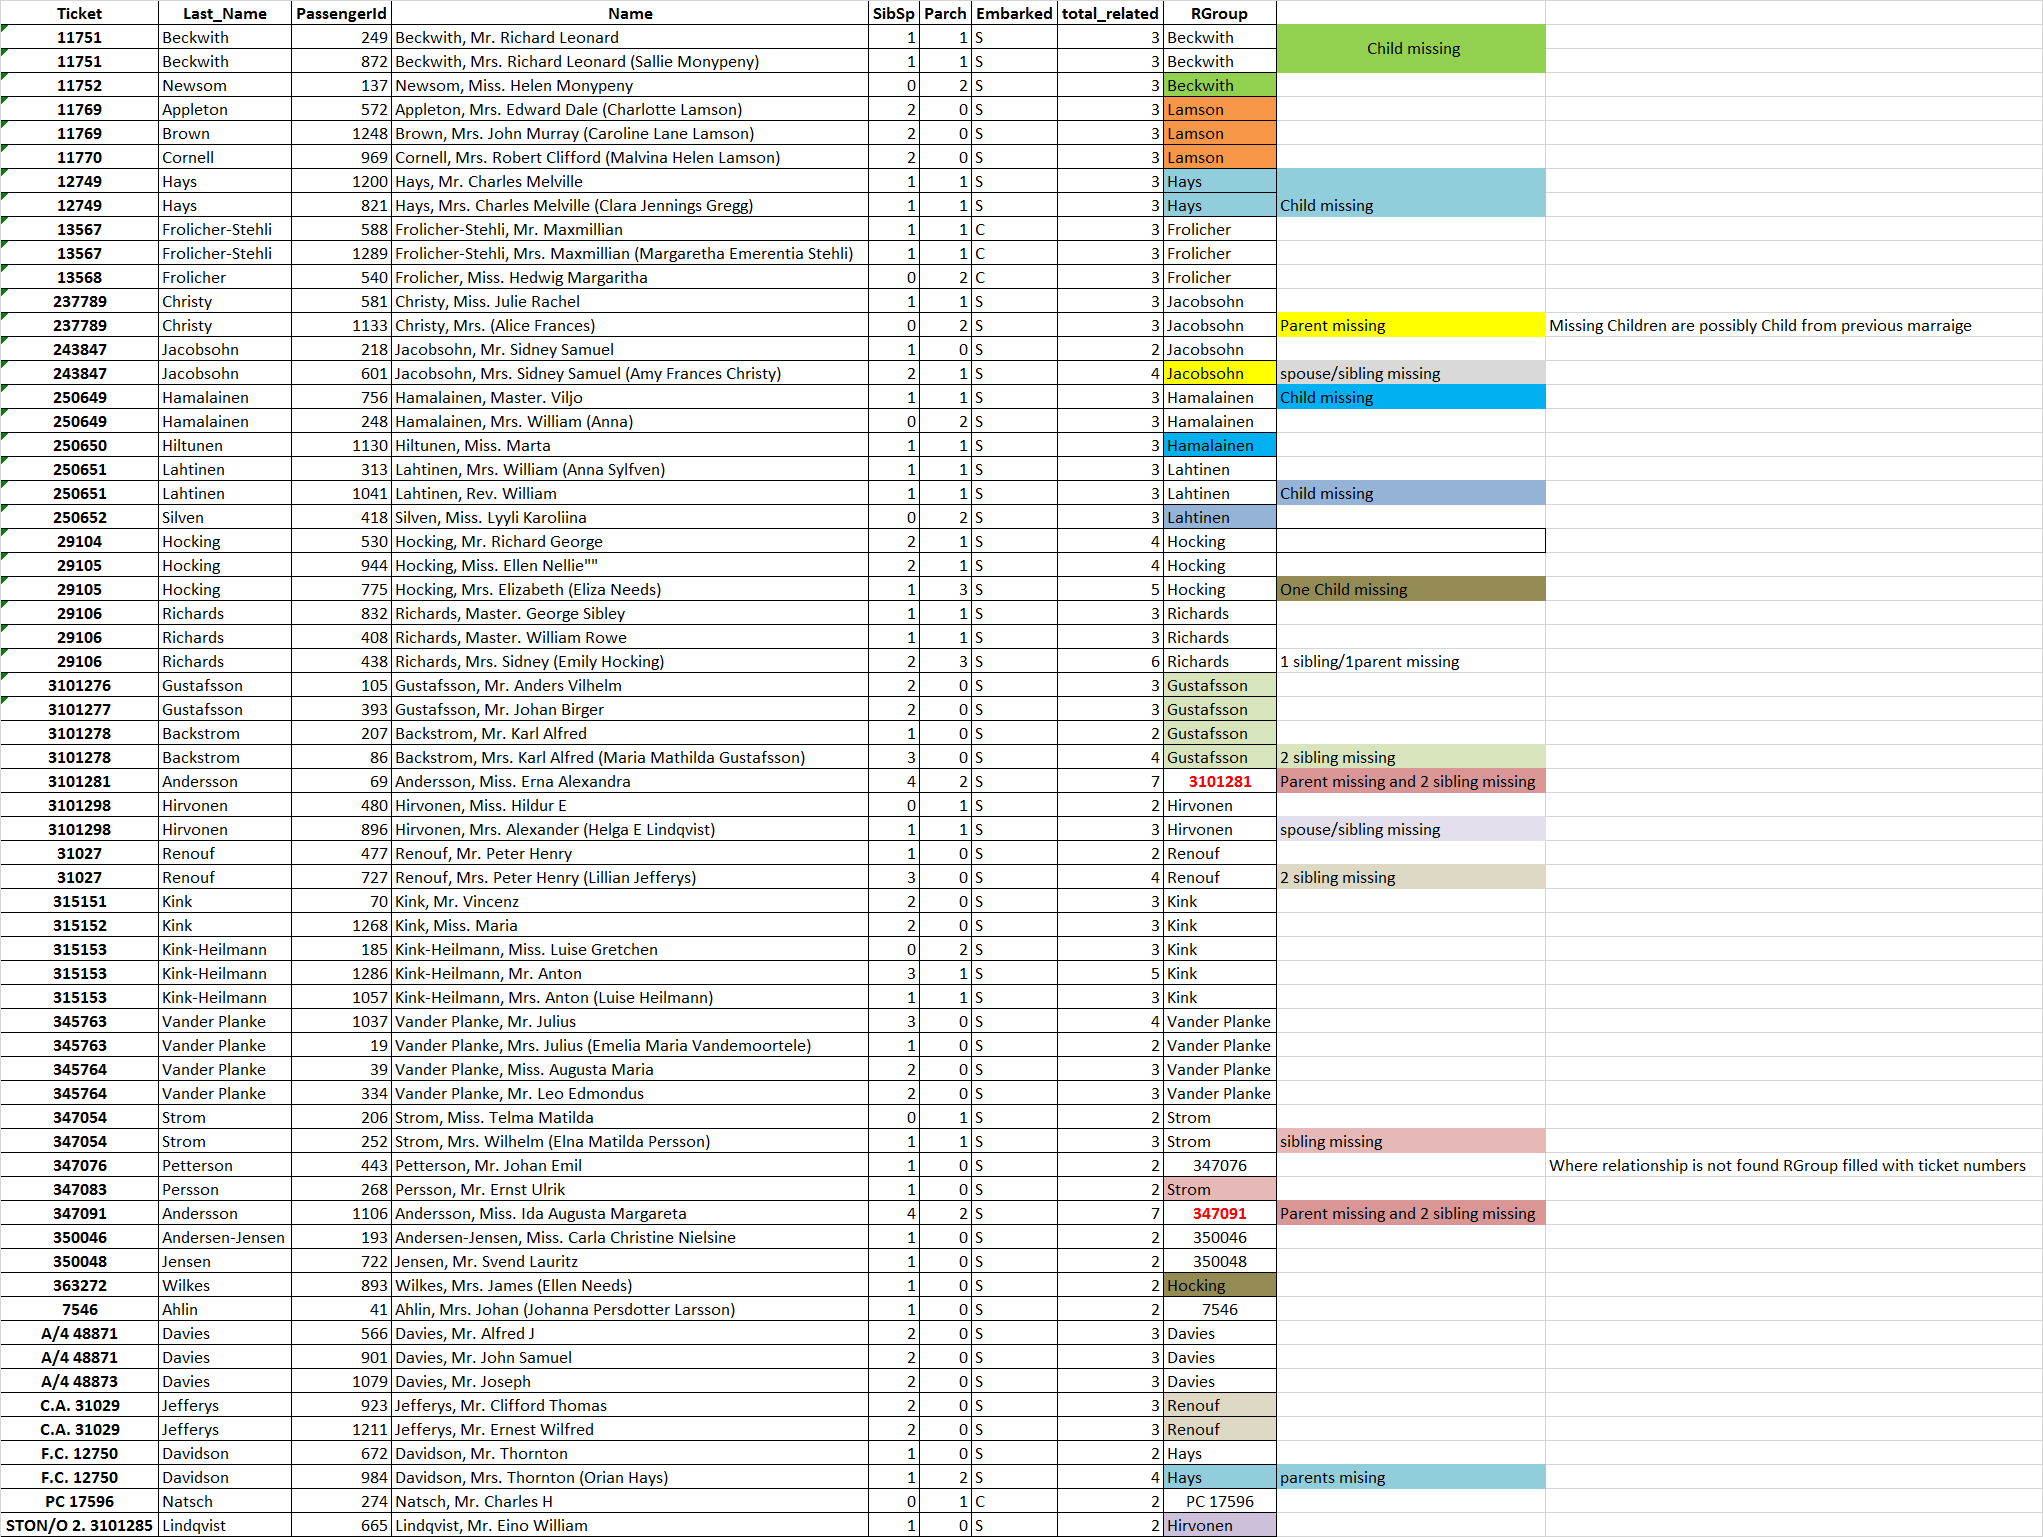

Update the remaining relationship group using the above table.

In [ ]:
related_people.loc[related_people["PassengerId"]==249,"RGroup"]="Beckwith_M"
related_people.loc[related_people["PassengerId"]==872,"RGroup"]="Beckwith_M"
related_people.loc[related_people["PassengerId"]==137,"RGroup"]="Beckwith_M"
related_people.loc[related_people["PassengerId"]==572,"RGroup"]="Lamson_M"
related_people.loc[related_people["PassengerId"]==1248,"RGroup"]="Lamson_M"
related_people.loc[related_people["PassengerId"]==969,"RGroup"]="Lamson_M"
related_people.loc[related_people["PassengerId"]==1200,"RGroup"]="Hays_M"
related_people.loc[related_people["PassengerId"]==821,"RGroup"]="Hays_M"
related_people.loc[related_people["PassengerId"]==588,"RGroup"]="Frolicher_M"
related_people.loc[related_people["PassengerId"]==1289,"RGroup"]="Frolicher_M"
related_people.loc[related_people["PassengerId"]==540,"RGroup"]="Frolicher_M"
related_people.loc[related_people["PassengerId"]==581,"RGroup"]="Jacobsohn_M"
related_people.loc[related_people["PassengerId"]==1133,"RGroup"]="Jacobsohn_M"
related_people.loc[related_people["PassengerId"]==218,"RGroup"]="Jacobsohn_M"
related_people.loc[related_people["PassengerId"]==601,"RGroup"]="Jacobsohn_M"
related_people.loc[related_people["PassengerId"]==756,"RGroup"]="Hamalainen_M"
related_people.loc[related_people["PassengerId"]==248,"RGroup"]="Hamalainen_M"
related_people.loc[related_people["PassengerId"]==1130,"RGroup"]="Hamalainen_M"
related_people.loc[related_people["PassengerId"]==313,"RGroup"]="Lahtinen_M"
related_people.loc[related_people["PassengerId"]==1041,"RGroup"]="Lahtinen_M"
related_people.loc[related_people["PassengerId"]==418,"RGroup"]="Lahtinen_M"
related_people.loc[related_people["PassengerId"]==530,"RGroup"]="Hocking_M"
related_people.loc[related_people["PassengerId"]==944,"RGroup"]="Hocking_M"
related_people.loc[related_people["PassengerId"]==775,"RGroup"]="Hocking_M"
related_people.loc[related_people["PassengerId"]==832,"RGroup"]="Richards_M"
related_people.loc[related_people["PassengerId"]==408,"RGroup"]="Richards_M"
related_people.loc[related_people["PassengerId"]==438,"RGroup"]="Richards_M"
related_people.loc[related_people["PassengerId"]==105,"RGroup"]="Gustafsson_M"
related_people.loc[related_people["PassengerId"]==393,"RGroup"]="Gustafsson_M"
related_people.loc[related_people["PassengerId"]==207,"RGroup"]="Gustafsson_M"
related_people.loc[related_people["PassengerId"]==86,"RGroup"]="Gustafsson_M"
related_people.loc[related_people["PassengerId"]==69,"RGroup"]="3101281"
related_people.loc[related_people["PassengerId"]==480,"RGroup"]="Hirvonen_M"
related_people.loc[related_people["PassengerId"]==896,"RGroup"]="Hirvonen_M"
related_people.loc[related_people["PassengerId"]==477,"RGroup"]="Renouf_M"
related_people.loc[related_people["PassengerId"]==727,"RGroup"]="Renouf_M"
related_people.loc[related_people["PassengerId"]==70,"RGroup"]="Kink_M"
related_people.loc[related_people["PassengerId"]==1268,"RGroup"]="Kink_M"
related_people.loc[related_people["PassengerId"]==185,"RGroup"]="Kink_M"
related_people.loc[related_people["PassengerId"]==1286,"RGroup"]="Kink_M"
related_people.loc[related_people["PassengerId"]==1057,"RGroup"]="Kink_M"
related_people.loc[related_people["PassengerId"]==1037,"RGroup"]="Vander Planke_M"
related_people.loc[related_people["PassengerId"]==19,"RGroup"]="Vander Planke_M"
related_people.loc[related_people["PassengerId"]==39,"RGroup"]="Vander Planke_M"
related_people.loc[related_people["PassengerId"]==334,"RGroup"]="Vander Planke_M"
related_people.loc[related_people["PassengerId"]==206,"RGroup"]="Strom_M"
related_people.loc[related_people["PassengerId"]==252,"RGroup"]="Strom_M"
related_people.loc[related_people["PassengerId"]==443,"RGroup"]="347076"
related_people.loc[related_people["PassengerId"]==268,"RGroup"]="Strom_M"
related_people.loc[related_people["PassengerId"]==1106,"RGroup"]="347091"
related_people.loc[related_people["PassengerId"]==193,"RGroup"]="350046"
related_people.loc[related_people["PassengerId"]==722,"RGroup"]="350048"
related_people.loc[related_people["PassengerId"]==893,"RGroup"]="Hocking_M"
related_people.loc[related_people["PassengerId"]==41,"RGroup"]="7546"
related_people.loc[related_people["PassengerId"]==566,"RGroup"]="Davies_M"
related_people.loc[related_people["PassengerId"]==901,"RGroup"]="Davies_M"
related_people.loc[related_people["PassengerId"]==1079,"RGroup"]="Davies_M"
related_people.loc[related_people["PassengerId"]==923,"RGroup"]="Renouf_M"
related_people.loc[related_people["PassengerId"]==1211,"RGroup"]="Renouf_M"
related_people.loc[related_people["PassengerId"]==672,"RGroup"]="Hays_M"
related_people.loc[related_people["PassengerId"]==984,"RGroup"]="Hays_M"
related_people.loc[related_people["PassengerId"]==274,"RGroup"]="PC 17596"
related_people.loc[related_people["PassengerId"]==665,"RGroup"]="Hirvonen_M"


Update the relation group in train_df

In [ ]:
related_people.drop(columns={"Ticket","Last_Name","Name","SibSp","Parch","total_related"})
related_people.set_index("PassengerId",inplace=True)
train_df["RGroup"]=""
train_df.set_index("PassengerId",inplace=True)
train_df.update(related_people)
train_df.reset_index(inplace=True)
related_people.reset_index(inplace=True) 
 


***4.6) Update of train data***

In [ ]:
train_df["Sex"]=train_df["Sex"].astype("category")
train_df["Pclass"]=train_df["Pclass"].astype("category")
train_df["Embarked"]=train_df["Embarked"].astype("category")
train_df["RGroup"]=train_df["RGroup"].astype("category")
#dropping column name and fare_group and Name Key
train_df.drop(columns={"Name","Fare_Group","Name_key","Ticket","PassengerId"},inplace=True)
#denormalize category data
train_df=pd.get_dummies(train_df,columns=["Pclass"])
train_df=pd.get_dummies(train_df,columns=["Sex"])
train_df=pd.get_dummies(train_df,columns=["Embarked"])

train_df.rename(columns={"Pclass_1.0":"Pclass_1","Pclass_2.0":"Pclass_2","Pclass_3.0":"Pclass_3"},inplace=True)


***4.7) Update of test data***

In [ ]:
#Age
test_df.set_index('PassengerId',inplace=True)
test_df.update(result)
test_df.reset_index(inplace=True)
#Name_key
#test_df["Name_key"]=""
#test_df["Name_key"]=test_df["Name"].str.split(',',expand=True)[1].str.split(' ',expand=True)[1]
#RGroup
related_people.set_index("PassengerId",inplace=True)
test_df["RGroup"]=""
test_df.set_index("PassengerId",inplace=True)
test_df.update(related_people)
test_df.reset_index(inplace=True)
related_people.reset_index(inplace=True) 
#categorical data
test_df["Sex"]=test_df["Sex"].astype("category")
test_df["Pclass"]=test_df["Pclass"].astype("category")
test_df["Embarked"]=test_df["Embarked"].astype("category")
test_df["RGroup"]=test_df["RGroup"].astype("category")
#test_df["Name_key"]=test_df["Name_key"].astype("category")
#dropping column name and Cabin 
test_df.drop(columns={"Name","Cabin","Ticket","PassengerId"},inplace=True)
#denormalize category data
test_df=pd.get_dummies(test_df,columns=["Pclass"])
test_df=pd.get_dummies(test_df,columns=["Sex"])
test_df=pd.get_dummies(test_df,columns=["Embarked"])
#test_df=pd.get_dummies(test_df,columns=["Name_key"])

**5) DECISION TREE PREDICTION**

            For decision tree RGroup cannot be used as categorical data is not supported.
            Doing binary encoding will give 82% accuracy but I dont find it to be correct to used . Doing label encoding will not help. Doing one-hot-mapping will
            increase dimensionality by 970 and cause overfitting.
            I have added a new column called 'percentage' which is the survival ratio of the people related together.

In [ ]:
#calculate 'percentage' -survival ration in same RGroup
R=train_df.groupby(["RGroup"])["Survived"].agg(["count","sum"])
R.reset_index(inplace=True)
R["percentage"]=R["sum"]/R["count"]
R.drop(columns={"count","sum"},inplace=True)

***5.1) FINAL TRAIN DATA UPDATE***

In [ ]:
R.set_index("RGroup",inplace=True)
train_df["percentage"]=""
train_df.set_index("RGroup",inplace=True)
train_df.update(R)
train_df.reset_index(inplace=True)
R.reset_index(inplace=True) 
train_df["percentage"]=train_df["percentage"].astype("float64")

***5.2) FINAL TEST DATA UPDATE***

In [ ]:
R.set_index("RGroup",inplace=True)
test_df["percentage"]=999
test_df.set_index("RGroup",inplace=True)
test_df.update(R)
test_df.reset_index(inplace=True)
R.reset_index(inplace=True) 
test_df["percentage"]=test_df["percentage"].astype("float64")

***5.3) CHECK THE CORRELATION MATRIX***
            
            The 'percentage' plays an important role.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_data=train_df.corr(method='pearson')
fig,ax=plt.subplots(figsize=(15,8))
mask=np.zeros_like(corr_data)
mask[np.tril_indices_from(mask)]=True
ax=sns.heatmap(corr_data,mask=mask,cmap="Blues",annot=True)

*Some questions:*

Do I need to standardized the data? 
> If I use decision tree  standardization is not important. If I use logistic regression then we need to standardized Age,Fare . 

***5.4) TRAIN MODEL***
            
            5.4.1) Find the optimal depth for decision tree.

In [ ]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split

#creating dataset for decision learning  
train_df_dec=train_df.copy()
Target_df=train_df_dec["Survived"].copy()                                      
train_df_dec.drop(columns={"RGroup","Survived"},inplace=True)
#Split Training data into Training and Validation set
X_train,X_cv,Y_train,Y_cv=train_test_split(train_df_dec,Target_df,test_size=0.33,random_state=0,shuffle=True)

#checking accuracy score for different dept
scores=[]
for x in range(1,7):
    clf=tree.DecisionTreeClassifier(criterion='entropy',max_depth=x) #I have tested and found the default depth is 11; accuracy score on validation set is 70% only
    clf=clf.fit(X_train,Y_train)
    Y_pred=clf.predict(X_cv)
    scores.append(metrics.accuracy_score(Y_cv,Y_pred))
print(scores)

     5.4.2) Check score on K-fold cross validation to confirm is overfitting in not there.


In [ ]:
from sklearn.model_selection import cross_val_score
clf=tree.DecisionTreeClassifier(criterion='entropy',max_depth=4) 
scores_cv = cross_val_score(clf, train_df_dec,Target_df, cv=8)
scores_cv

    5.4.3) View Decision tree graph.

In [ ]:
# max performance is in depth 3, depth 4 is near to it
clf=tree.DecisionTreeClassifier(criterion='entropy',max_depth=4) 
clf=clf.fit(X_train,Y_train)
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X_train.columns.values.tolist()) 
graph = graphviz.Source(dot_data)
graph

    This is my model which give 98% accuracy in prediction on the cross validation set. Is this right or overfitted? 

***5.5) PREDICTION ON TEST DATA ***

In [ ]:

Y_pred=clf.predict(test_df)
my_submission = pd.DataFrame({'PassengerId': test_df["PassengerId"], 'Suvived': Y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

